<a href="https://colab.research.google.com/github/R3beAM/Laboratorio-2-Modelos-de-lenguaje/blob/main/Lab2_ModelosLenguaje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br>

#### Activity 2: Exploring Word Embeddings with GloVe and Numpy
<br>

- Objective:
    - To understand the concept of word embeddings and their significance in Natural Language Processing.
    - To learn how to manipulate and visualize high-dimensional data using dimensionality reduction techniques like PCA and t-SNE.
    - To gain hands-on experience in implementing word similarity and analogies using GloVe embeddings and Numpy.
    
<br>

- Instructions:
    - Download GloVe pre-trained vectors from the provided link in Canvas, the official public project:
    Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation
    https://nlp.stanford.edu/data/glove.6B.zip

    - Create a dictorionay of the embeddings so that you carry out fast look ups. Save that dictionary e.g. as a serialized file for faster loading in future uses.
    
    - PCA and t-SNE Visualization: After loading the GloVe embeddings, use Numpy and Sklearn to perform PCA and t-SNE to reduce the dimensionality of the embeddings and visualize them in a 2D or 3D space.

    - Word Similarity: Implement a function that takes a word as input and returns the 'n' most similar words based on their embeddings. You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Word Analogies: Implement a function to solve analogies between words. For example, "man is to king as woman is to ____". You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Submission: This activity is to be submitted in teams of 3 or 4. Only one person should submit the final work, with the full names of all team members included in a markdown cell at the beginning of the notebook.
    
<br>

- Evaluation Criteria:

    - Code Quality (40%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity.
    
   - Functionality (60%): All functions should work as intended, without errors.
       - Visualization of PCA and t-SNE (10% each for a total of 20%)
       - Similarity function (20%)
       - Analogy function (20%)
|



#### Import libraries

In [7]:
# Import libraries
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import pickle
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/glove.6B.50d.txt'
plt.style.use('ggplot')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Load file

In [29]:
# PATH = '/media/pepe/DataUbuntu/Databases/glove_embeddings/glove.6B.200d.txt'
PATH = '/content/drive/MyDrive/glove.6B.50d.txt'
emb_dim = 50

In [23]:
# Create dictionary with embeddings
def create_emb_dictionary(path="/content/drive/MyDrive/glove.6B.50d.txt"):

    embeddings = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            word, *vector = parts
            values = np.asarray(vector, dtype=np.float32)
            embeddings[word] = torch.from_numpy(values)
    return embeddings

In [25]:
# create dictionary
embeddings_dict = create_emb_dictionary("/content/drive/MyDrive/glove.6B.50d.txt")

In [30]:
# Serialize
with open('embeddings_dict_50D.pkl', 'wb') as f:
    pickle.dump(embeddings_dict, f)

# Deserialize
# with open('embeddings_dict_200D.pkl', 'rb') as f:
#     embeddings_dict = pickle.load(f)

#### See some embeddings

In [31]:
# Show some
def show_n_first_words(path, n_words):
        with open(path, 'r') as f:
            for i, line in enumerate(f):
                print(line.split(), len(line.split()[1:]))
                if i>=n_words: break

In [32]:
show_n_first_words(PATH, 5)

['the', '0.418', '0.24968', '-0.41242', '0.1217', '0.34527', '-0.044457', '-0.49688', '-0.17862', '-0.00066023', '-0.6566', '0.27843', '-0.14767', '-0.55677', '0.14658', '-0.0095095', '0.011658', '0.10204', '-0.12792', '-0.8443', '-0.12181', '-0.016801', '-0.33279', '-0.1552', '-0.23131', '-0.19181', '-1.8823', '-0.76746', '0.099051', '-0.42125', '-0.19526', '4.0071', '-0.18594', '-0.52287', '-0.31681', '0.00059213', '0.0074449', '0.17778', '-0.15897', '0.012041', '-0.054223', '-0.29871', '-0.15749', '-0.34758', '-0.045637', '-0.44251', '0.18785', '0.0027849', '-0.18411', '-0.11514', '-0.78581'] 50
[',', '0.013441', '0.23682', '-0.16899', '0.40951', '0.63812', '0.47709', '-0.42852', '-0.55641', '-0.364', '-0.23938', '0.13001', '-0.063734', '-0.39575', '-0.48162', '0.23291', '0.090201', '-0.13324', '0.078639', '-0.41634', '-0.15428', '0.10068', '0.48891', '0.31226', '-0.1252', '-0.037512', '-1.5179', '0.12612', '-0.02442', '-0.042961', '-0.28351', '3.5416', '-0.11956', '-0.014533', '-0.

### Plot some embeddings

In [28]:

#Add PCA and t-SNE visualization

def plot_embeddings(emb_path, words2show, emb_dim, embeddings_dict, func=PCA, n_components=2, random_state=42):
    """Reduce the dimensionality of selected embeddings and plot them.

    Parameters
    ----------
    emb_path : str
        Path to the embeddings file (kept for backwards compatibility).
    words2show : Iterable[str]
        Collection of tokens to visualise.
    emb_dim : int
        Dimensionality of the embeddings (unused but kept for clarity).
    embeddings_dict : Dict[str, torch.Tensor]
        Dictionary mapping tokens to their embedding vectors.
    func : Callable
        A dimensionality reduction class from sklearn (e.g. PCA or TSNE).
    n_components : int, optional
        Number of dimensions to project to. Defaults to 2.
    random_state : int, optional
        Random seed used by stochastic reducers such as t-SNE.
    """
    import inspect

    vectors = []
    labels = []
    for word in words2show:
        vector = embeddings_dict.get(word)
        if vector is None:
            print(f"Word '{word}' not found in the embeddings dictionary.")
            continue
        # ensure numpy array
        vectors.append(vector.cpu().numpy())
        labels.append(word)

    if not vectors:
        raise ValueError("No valid words were provided to plot.")

    matrix = np.vstack(vectors)

    reducer_kwargs = {"n_components": n_components}
    if func is TSNE:
        # perplexity must be less than the number of samples
        max_perplexity = max(1, len(labels) - 1)
        perplexity = min(30, max_perplexity)
        if perplexity < 5 and max_perplexity >= 5:
            perplexity = max_perplexity
        reducer_kwargs.update({
            "random_state": random_state,
            "init": "pca",
            "learning_rate": "auto",
            "perplexity": perplexity
        })
    else:
        params = inspect.signature(func.__init__).parameters
        if "random_state" in params:
            reducer_kwargs["random_state"] = random_state

    reducer = func(**reducer_kwargs)
    reduced = reducer.fit_transform(matrix)

    if n_components not in (2, 3):
        raise ValueError("Only 2D or 3D plots are supported.")

    if n_components == 2:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.scatter(reduced[:, 0], reduced[:, 1], alpha=0.7)
        for label, x, y in zip(labels, reduced[:, 0], reduced[:, 1]):
            ax.annotate(label, (x, y))
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
    else:
        from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 - imported for side effects
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(reduced[:, 0], reduced[:, 1], reduced[:, 2], alpha=0.7)
        for label, x, y, z in zip(labels, reduced[:, 0], reduced[:, 1], reduced[:, 2]):
            ax.text(x, y, z, label)
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_zlabel("Component 3")

    ax.set_title(f"{func.__name__} projection of GloVe embeddings")
    plt.show()

    return {"labels": labels, "embeddings": reduced}

In [33]:
words= ['burger', 'tortilla', 'bread', 'pizza', 'beef', 'steak', 'fries', 'chips',
            'argentina', 'mexico', 'spain', 'usa', 'france', 'italy', 'greece', 'china',
            'water', 'beer', 'tequila', 'wine', 'whisky', 'brandy', 'vodka', 'coffee', 'tea',
            'apple', 'banana', 'orange', 'lemon', 'grapefruit', 'grape', 'strawberry', 'raspberry',
            'school', 'work', 'university', 'highschool']


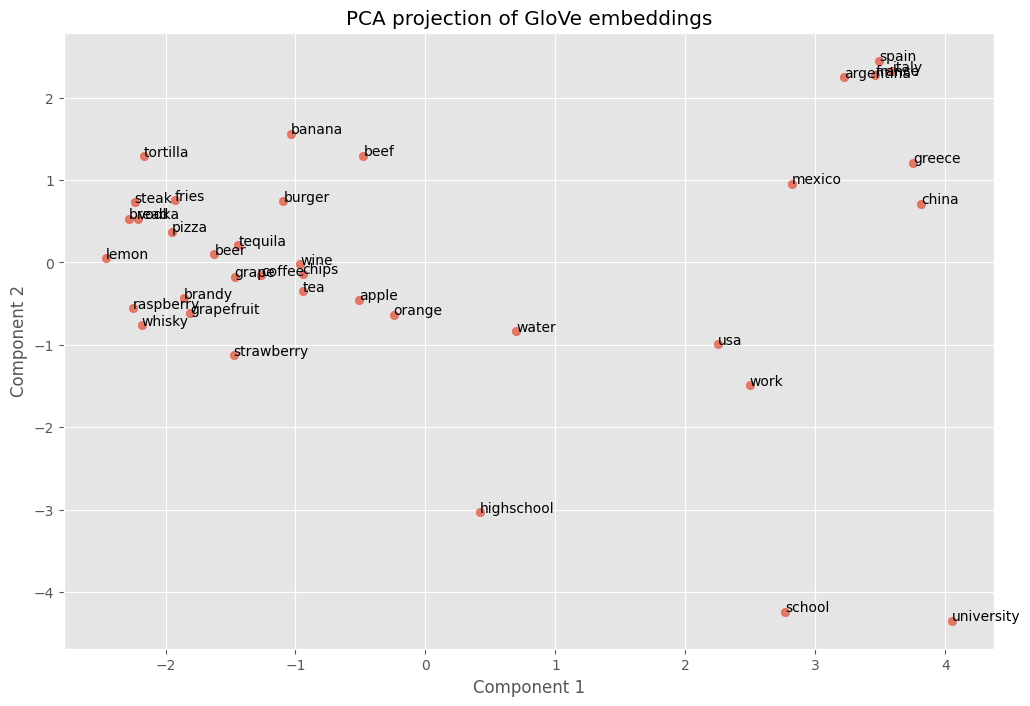

{'labels': ['burger',
  'tortilla',
  'bread',
  'pizza',
  'beef',
  'steak',
  'fries',
  'chips',
  'argentina',
  'mexico',
  'spain',
  'usa',
  'france',
  'italy',
  'greece',
  'china',
  'water',
  'beer',
  'tequila',
  'wine',
  'whisky',
  'brandy',
  'vodka',
  'coffee',
  'tea',
  'apple',
  'banana',
  'orange',
  'lemon',
  'grapefruit',
  'grape',
  'strawberry',
  'raspberry',
  'school',
  'work',
  'university',
  'highschool'],
 'embeddings': array([[-1.0925041 ,  0.74372876],
        [-2.1670628 ,  1.292367  ],
        [-2.2834158 ,  0.52902204],
        [-1.9500184 ,  0.3721772 ],
        [-0.47766322,  1.2940513 ],
        [-2.2378066 ,  0.7307441 ],
        [-1.92657   ,  0.75569266],
        [-0.9450014 , -0.13504937],
        [ 3.2193754 ,  2.246692  ],
        [ 2.8189163 ,  0.95552075],
        [ 3.488131  ,  2.4482503 ],
        [ 2.2472813 , -0.9943583 ],
        [ 3.4618902 ,  2.269228  ],
        [ 3.5916219 ,  2.3245144 ],
        [ 3.7501671 ,  1.2115

In [34]:
#
plot_embeddings(PATH, words, emb_dim, embeddings_dict, PCA)

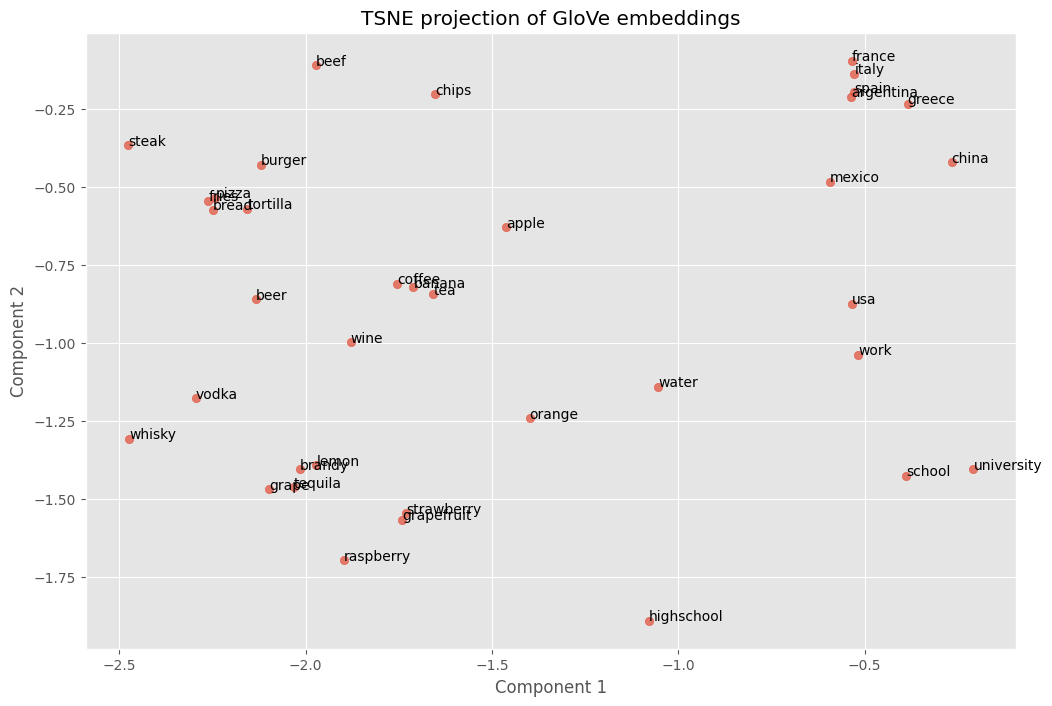

In [36]:
# t-SNE dimensionality reduction for visualization
embeddings = plot_embeddings(PATH, words, emb_dim, embeddings_dict, TSNE)

#**Word Analogies and Similarities**

In [61]:
"""Utilities for solving word analogies using NumPy vectors."""
from __future__ import annotations

from typing import Mapping, Sequence, Tuple, Union, List

import numpy as np


VectorLike = Union[Sequence[float], np.ndarray]


def _normalize_rows(matrix: np.ndarray) -> np.ndarray:
    """Return a row-wise L2 normalized copy of ``matrix``.

    Rows with zero norm are left untouched to avoid division by zero.
    """
    norms = np.linalg.norm(matrix, axis=1, keepdims=True)
    # Avoid division by zero: keep zero rows unchanged.
    normalized = matrix.copy()
    non_zero_rows = norms[:, 0] > 0
    normalized[non_zero_rows] /= norms[non_zero_rows]
    return normalized


def solve_analogy(
    word_a: str,
    word_b: str,
    word_c: str,
    embeddings: Mapping[str, VectorLike],
    *,
    top_k: int = 1,
) -> Union[str, List[Tuple[str, float]]]:
    """Solve analogies of the form ``a`` is to ``b`` as ``c`` is to ``?``.

    Parameters
    ----------
    word_a, word_b, word_c:
        Words that define the analogy ``a : b :: c : ?``. All three words must
        be present in ``embeddings``.
    embeddings:
        Mapping from words to vector representations. All vectors must share
        the same dimensionality. Any ``Sequence`` convertible to a NumPy array
        is accepted.
    top_k:
        Number of best-scoring candidates to return. When ``top_k`` is ``1``
        (the default), a single word is returned. For larger values, a list of
        ``(word, score)`` tuples ordered by decreasing cosine similarity is
        returned.

    Returns
    -------
    str or list of (str, float)
        The best candidate completing the analogy, or a list of top candidates
        with their cosine similarity scores when ``top_k`` > 1.

    Raises
    ------
    ValueError
        If a word is missing from ``embeddings``, the vectors have inconsistent
        dimensions, or ``top_k`` is less than 1.
    """

    if top_k < 1:
        raise ValueError("top_k must be greater than or equal to 1")

    required_words = (word_a, word_b, word_c)
    for word in required_words:
        if word not in embeddings:
            raise ValueError(f"Word '{word}' not found in the embeddings.")

    words: List[str] = []
    vectors: List[np.ndarray] = []
    vector_length = None

    for word, vector in embeddings.items():
        arr = np.asarray(vector, dtype=np.float64)
        if arr.ndim != 1:
            raise ValueError("Embedding vectors must be one-dimensional.")
        if vector_length is None:
            vector_length = arr.shape[0]
        elif arr.shape[0] != vector_length:
            raise ValueError("All embedding vectors must share the same length.")
        words.append(word)
        vectors.append(arr)

    matrix = np.vstack(vectors)
    normalized_matrix = _normalize_rows(matrix)

    word_to_index = {word: idx for idx, word in enumerate(words)}
    vec_a = normalized_matrix[word_to_index[word_a]]
    vec_b = normalized_matrix[word_to_index[word_b]]
    vec_c = normalized_matrix[word_to_index[word_c]]

    target_vector = vec_b - vec_a + vec_c
    target_norm = np.linalg.norm(target_vector)
    if target_norm == 0:
        raise ValueError("The analogy target vector has zero length.")
    target_vector /= target_norm

    similarities = normalized_matrix @ target_vector

    excluded_indices = {word_to_index[word] for word in required_words}
    similarities[list(excluded_indices)] = -np.inf

    top_k = min(top_k, len(words) - len(excluded_indices))
    if top_k <= 0:
        raise ValueError("Not enough candidate words to compute the analogy.")

    best_indices = np.argpartition(-similarities, top_k - 1)[:top_k]
    # Sort the selected candidates by similarity in descending order.
    best_indices = best_indices[np.argsort(-similarities[best_indices])]

    if top_k == 1:
        return words[int(best_indices[0])]

    return [(words[int(idx)], float(similarities[int(idx)])) for idx in best_indices]


def most_similar(
    word: str,
    embeddings: Mapping[str, VectorLike],
    *,
    top_n: int = 5,
) -> List[Tuple[str, float]]:
    """Return the ``top_n`` words most similar to ``word`` using cosine similarity.

    Parameters
    ----------
    word:
        Reference word whose neighbours we want to retrieve. It must be present
        in ``embeddings``.
    embeddings:
        Mapping from words to vector representations. All vectors must share the
        same dimensionality. Any ``Sequence`` convertible to a NumPy array is
        accepted.
    top_n:
        Number of similar words to retrieve. Must be at least 1.

    Returns
    -------
    list of (str, float)
        A list with the closest words and their cosine similarity to ``word``
        ordered from most to least similar.

    Raises
    ------
    ValueError
        If ``word`` is missing, the vectors have inconsistent dimensions or
        ``top_n`` is less than 1.
    """

    if top_n < 1:
        raise ValueError("top_n must be greater than or equal to 1")

    if word not in embeddings:
        raise ValueError(f"Word '{word}' not found in the embeddings.")

    words: List[str] = []
    vectors: List[np.ndarray] = []
    vector_length = None

    for current_word, vector in embeddings.items():
        arr = np.asarray(vector, dtype=np.float64)
        if arr.ndim != 1:
            raise ValueError("Embedding vectors must be one-dimensional.")
        if vector_length is None:
            vector_length = arr.shape[0]
        elif arr.shape[0] != vector_length:
            raise ValueError("All embedding vectors must share the same length.")
        words.append(current_word)
        vectors.append(arr)

    matrix = np.vstack(vectors)
    normalized_matrix = _normalize_rows(matrix)

    word_to_index = {current_word: idx for idx, current_word in enumerate(words)}
    reference_vector = normalized_matrix[word_to_index[word]]

    similarities = normalized_matrix @ reference_vector

    # Exclude the reference word from the results by setting its similarity to
    # negative infinity.
    similarities[word_to_index[word]] = -np.inf

    available_candidates = len(words) - 1
    top_n = min(top_n, available_candidates)
    if top_n <= 0:
        raise ValueError("Not enough candidate words to compute similarities.")

    best_indices = np.argpartition(-similarities, top_n - 1)[:top_n]
    best_indices = best_indices[np.argsort(-similarities[best_indices])]

    return [(words[int(idx)], float(similarities[int(idx)])) for idx in best_indices]


__all__ = ["solve_analogy", "most_similar"]

### Let us compute analogies

In [54]:
# analogy
def analogy(word1, word2, word3, embeddings_dict):
    pass

In [55]:
analogy('man', 'king', 'woman', embeddings_dict)

In [56]:
# most similar
def find_most_similar(word, embeddings_dict, top_n=10):
    return most_similar(word, embeddings_dict, top_n=top_n)